**Solar Panel Object Detection Project**

1. **Data Exploration and Understanding**  
    - Counting total instances of solar panels  
    - Value counts of labels per image  
    - Computing area (in m²) statistics and plotting histogram  
 
 2. **Implementing the Fundamental Functions**  
    - IoU computation using the `shapely` library  
    - Average Precision (AP) computation using three different methods:
         - Pascal VOC 11-point interpolation  
         - COCO 101-point interpolation  
         - Area under the Precision-Recall curve  
    - Generating random images and boxes to compare AP@50 using these methods  
 
 3. **Model Building and Evaluation**  
    - Splitting data (80-20 train-test with 10% of training as validation)  
    - (Placeholder) Training a YOLO model from Ultralytics  
    - Visualizing predictions vs. ground truth on sample images  
    - Computing mAP50 using the `supervision` library and comparing with our implementation  
    - Creating a table of Precision, Recall, and F1-scores across various IoU and confidence thresholds

In [2]:

import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import cv2

from shapely.geometry import box as shapely_box

import supervision as sv  
from ultralytics import YOLO  

**1. Calculation of No. of Instances in the Dataset and show the value counts of labels per image.**

In [3]:
CHIP_SIZE_NATIVE = 416
CHIP_SIZE_HD = 832

In [4]:
LABELS_NATIVE_DIR = r'C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\labels-20250212T103318Z-001\labels\labels_native'
LABELS_HD_DIR = r'C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\labels-20250212T103318Z-001\labels\labels_hd'
IMAGES_DIR = r'C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\image_chips_native-20250212T103727Z-001\image_chips_native'

In [5]:
geotransforms = {
    1: (307670.04, 0.31, 0.0, 5434427.100000001, 0.0, -0.31),
    2: (312749.08, 0.31, 0.0, 5403952.860000001, 0.0, -0.31),
    3: (312749.08, 0.31, 0.0, 5363320.540000001, 0.0, -0.31)
}

In [6]:
def load_labels_from_folder(labels_folder, chip_size=CHIP_SIZE_NATIVE):
    """
    Loads label files from a given folder.
    Each file is assumed to correspond to one image chip.
    Returns:
      - total_instances: Total number of objects.
      - image_label_counts: A dict mapping image (file) name to number of labels.
      - annotations: List of annotations as dicts containing file, category, and normalized values.
    """
    total_instances = 0
    image_label_counts = {}
    annotations = []
    
    label_files = [f for f in os.listdir(labels_folder) if f.endswith('.txt')]
    
    for fname in label_files:
        fpath = os.path.join(labels_folder, fname)
        with open(fpath, 'r') as f:
            lines = f.readlines()
        count = len(lines)
        image_label_counts[fname] = count
        total_instances += count
        
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # skip malformed lines
            category, x_center, y_center, x_width, y_width = map(float, parts)
            annotations.append({
                'file': fname,
                'category': int(category),
                'x_center': x_center,
                'y_center': y_center,
                'x_width': x_width,
                'y_width': y_width,
                'chip_size': chip_size
            })
    
    return total_instances, image_label_counts, annotations

# Load native labels
total_instances_native, image_label_counts_native, annotations_native = load_labels_from_folder(LABELS_NATIVE_DIR, CHIP_SIZE_NATIVE)
print("Total solar panel instances (native):", total_instances_native)

# Compute value counts: e.g., how many images have 0 labels, 1 label, etc.
value_counts = defaultdict(int)
for count in image_label_counts_native.values():
    value_counts[count] += 1

print("\nValue counts (native labels):")
for label_count in sorted(value_counts.keys()):
    print(f"{value_counts[label_count]} images have {label_count} label(s)")

Total solar panel instances (native): 29625

Value counts (native labels):
81 images have 1 label(s)
167 images have 2 label(s)
221 images have 3 label(s)
218 images have 4 label(s)
217 images have 5 label(s)
189 images have 6 label(s)
170 images have 7 label(s)
184 images have 8 label(s)
169 images have 9 label(s)
121 images have 10 label(s)
97 images have 11 label(s)
84 images have 12 label(s)
69 images have 13 label(s)
49 images have 14 label(s)
46 images have 15 label(s)
41 images have 16 label(s)
36 images have 17 label(s)
25 images have 18 label(s)
29 images have 19 label(s)
14 images have 20 label(s)
4 images have 21 label(s)
1 images have 22 label(s)
4 images have 23 label(s)
2 images have 24 label(s)
4 images have 25 label(s)
3 images have 26 label(s)
5 images have 27 label(s)
5 images have 28 label(s)
15 images have 29 label(s)
20 images have 30 label(s)
8 images have 31 label(s)
7 images have 32 label(s)
13 images have 33 label(s)
19 images have 34 label(s)
10 images have 35

In [7]:
def load_labels_from_folder_hd(labels_folder, chip_size=CHIP_SIZE_HD):
    """
    Loads label files from a given folder.
    Each file is assumed to correspond to one image chip.
    Returns:
      - total_instances: Total number of objects.
      - image_label_counts: A dict mapping image (file) name to number of labels.
      - annotations: List of annotations as dicts containing file, category, and normalized values.
    """
    total_instances = 0
    image_label_counts = {}
    annotations = []
    
    label_files = [f for f in os.listdir(labels_folder) if f.endswith('.txt')]
    
    for fname in label_files:
        fpath = os.path.join(labels_folder, fname)
        with open(fpath, 'r') as f:
            lines = f.readlines()
        count = len(lines)
        image_label_counts[fname] = count
        total_instances += count
        
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # skip malformed lines
            category, x_center, y_center, x_width, y_width = map(float, parts)
            annotations.append({
                'file': fname,
                'category': int(category),
                'x_center': x_center,
                'y_center': y_center,
                'x_width': x_width,
                'y_width': y_width,
                'chip_size': chip_size
            })
    
    return total_instances, image_label_counts, annotations

# Load native labels
total_instances_hd, image_label_counts_hd, annotations_hd = load_labels_from_folder_hd(LABELS_HD_DIR, CHIP_SIZE_HD)
print("Total solar panel instances (hd):", total_instances_hd)

# Compute value counts: e.g., how many images have 0 labels, 1 label, etc.
value_counts = defaultdict(int)
for count in image_label_counts_hd.values():
    value_counts[count] += 1

print("\nValue counts (hd labels):")
for label_count in sorted(value_counts.keys()):
    print(f"{value_counts[label_count]} images have {label_count} label(s)")

Total solar panel instances (hd): 29880

Value counts (hd labels):
82 images have 1 label(s)
170 images have 2 label(s)
202 images have 3 label(s)
229 images have 4 label(s)
219 images have 5 label(s)
202 images have 6 label(s)
171 images have 7 label(s)
164 images have 8 label(s)
175 images have 9 label(s)
132 images have 10 label(s)
97 images have 11 label(s)
77 images have 12 label(s)
73 images have 13 label(s)
53 images have 14 label(s)
42 images have 15 label(s)
37 images have 16 label(s)
32 images have 17 label(s)
30 images have 18 label(s)
29 images have 19 label(s)
13 images have 20 label(s)
6 images have 21 label(s)
4 images have 22 label(s)
4 images have 23 label(s)
4 images have 24 label(s)
1 images have 25 label(s)
7 images have 26 label(s)
4 images have 27 label(s)
4 images have 28 label(s)
21 images have 29 label(s)
9 images have 30 label(s)
7 images have 31 label(s)
6 images have 32 label(s)
8 images have 33 label(s)
20 images have 34 label(s)
10 images have 35 label(s)


**2. Computing Area Statistics: For each annotation in the native labels and hd labels, we compute the area in square meters.**


2(a) 
The area for a single instance is computed by:

Converting Normalized Dimensions to Pixels:
The annotation provides normalized values for the width (x_width) and height (y_width). These values are multiplied by the chip size (416 for native images, 832 for HD images) to obtain the absolute dimensions in pixels.

Converting Pixels to Meters:
The pixel dimensions are then converted to real-world dimensions using a conversion factor. For native images, each pixel is 0.31 m, and for HD images, each pixel is 0.155 m.

Computing the Area:
The area is finally calculated by multiplying the width (in meters) by the height (in meters).

2(b)
Histogram and Mean, Standard Deviation


Area statistics (in m²) for native labels: Mean = 191.5178, Std = 630.7003


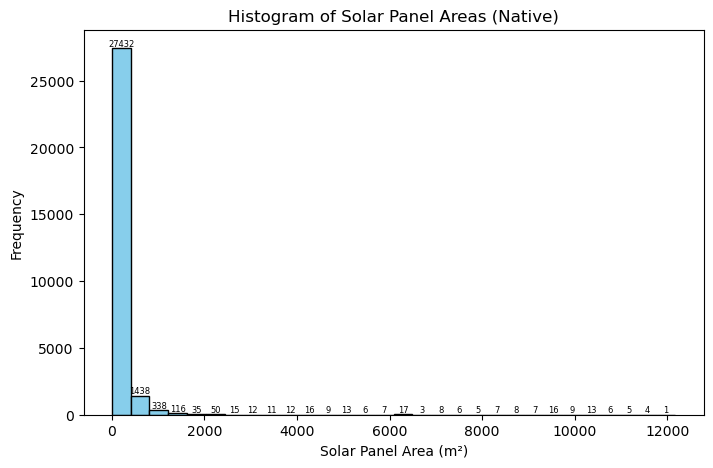

In [8]:
def compute_area_m2(annotation):
    chip_size = annotation['chip_size']
    # Compute absolute dimensions in pixels
    abs_width = annotation['x_width'] * chip_size
    abs_height = annotation['y_width'] * chip_size
    # Convert pixels to meters (each pixel is 0.31 m)
    width_m = abs_width * 0.31
    height_m = abs_height * 0.31
    return width_m * height_m

areas_m2 = [compute_area_m2(ann) for ann in annotations_native]

mean_area = np.mean(areas_m2)
std_area = np.std(areas_m2)
print(f"\nArea statistics (in m²) for native labels: Mean = {mean_area:.4f}, Std = {std_area:.4f}")
# Plot histogram of areas
plt.figure(figsize=(8,5))
counts, bins, patches = plt.hist(areas_m2, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Solar Panel Area (m²)')
plt.ylabel('Frequency')
plt.title('Histogram of Solar Panel Areas (Native)')
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width()/2, count, f'{int(count)}',
             ha='center', va='bottom', fontsize=6)
plt.show()

# Observation: Inspect the histogram for the distribution of solar panel sizes.



Area statistics (in m²) for HD labels: Mean = 188.6334, Std = 607.5349


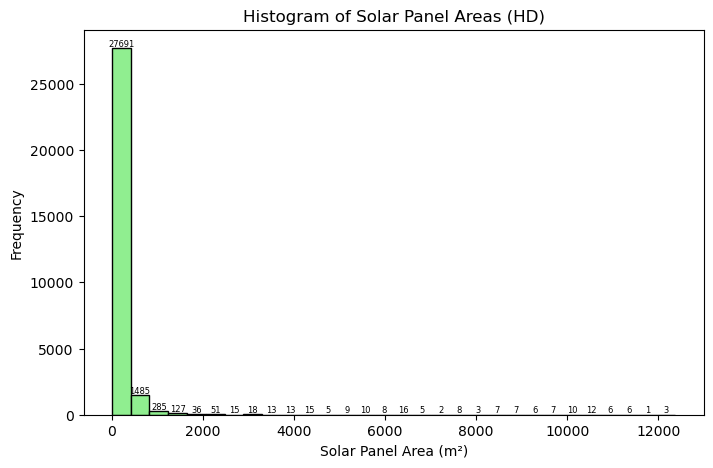

In [9]:
def compute_area_m2_hd(annotation):
    chip_size = annotation['chip_size']
    # Compute absolute dimensions in pixels
    abs_width = annotation['x_width'] * chip_size
    abs_height = annotation['y_width'] * chip_size
    # Convert pixels to meters (each pixel is 0.155 m)
    width_m = abs_width * 0.155
    height_m = abs_height * 0.155
    return width_m * height_m

areas_m2_hd = [compute_area_m2_hd(ann) for ann in annotations_hd]

mean_area_hd = np.mean(areas_m2_hd)
std_area_hd = np.std(areas_m2_hd)
print(f"\nArea statistics (in m²) for HD labels: Mean = {mean_area_hd:.4f}, Std = {std_area_hd:.4f}")

# Plot histogram of areas
plt.figure(figsize=(8,5))
counts, bins, patches = plt.hist(areas_m2_hd, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Solar Panel Area (m²)')
plt.ylabel('Frequency')
plt.title('Histogram of Solar Panel Areas (HD)')
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width()/2, count, f'{int(count)}',
             ha='center', va='bottom', fontsize=6)
plt.show()

# Observation: Inspect the histogram for the distribution of solar panel sizes.


2(c) Histogram Analysis

The histogram indicates that most of the annotated solar panels have relatively small areas (i.e., the left side of the graph has a high frequency). As we move to larger area bins, the frequency gradually decreases. This suggests a right-skewed distribution where the majority of solar panels in the dataset are small, with only a few instances of larger panels. This observation might reflect the actual size distribution in the imagery or differences in how the annotations were made between the two resolutions.

**Implementing the Fundamental Functions**

In [10]:
def iou_shapely_yolo(box1, box2):
    """
    Compute IoU for two boxes in YOLO format: [x_center, y_center, width, height]
    (with values in the same scale, e.g. pixel coordinates or normalized values).
    This function converts them to (xmin, ymin, xmax, ymax) and uses Shapely.
    """
    def yolo_to_xyxy(box, chip_size=1):
        # if box values are normalized, multiply by chip_size; if already absolute, chip_size=1.
        x_center, y_center, w, h = box
        x_center *= chip_size
        y_center *= chip_size
        w *= chip_size
        h *= chip_size
        xmin = x_center - w/2
        ymin = y_center - h/2
        xmax = x_center + w/2
        ymax = y_center + h/2
        return xmin, ymin, xmax, ymax

    x1_min, y1_min, x1_max, y1_max = yolo_to_xyxy(box1, chip_size=1)
    x2_min, y2_min, x2_max, y2_max = yolo_to_xyxy(box2, chip_size=1)

    poly1 = shapely_box(x1_min, y1_min, x1_max, y1_max)
    poly2 = shapely_box(x2_min, y2_min, x2_max, y2_max)

    intersection_area = poly1.intersection(poly2).area
    union_area = poly1.area + poly2.area - intersection_area
    return intersection_area / union_area if union_area > 0 else 0.0

box_a = [0.5, 0.5, 0.2, 0.2]  
box_b = [0.55, 0.55, 0.2, 0.2]
iou_value = iou_shapely_yolo(box_a, box_b)
print("\nIoU (Shapely) between box_a and box_b:", iou_value)



IoU (Shapely) between box_a and box_b: 0.39130434782608664


In [11]:
def yolo_to_xyxy(box):
    x_center, y_center, w, h = box
    xmin = x_center - w / 2
    ymin = y_center - h / 2
    xmax = x_center + w / 2
    ymax = y_center + h / 2
    return [xmin, ymin, xmax, ymax]

box_a_xyxy = yolo_to_xyxy(box_a)
box_b_xyxy = yolo_to_xyxy(box_b)
boxes_true = np.array([box_a_xyxy])
boxes_detection = np.array([box_b_xyxy])

iou_batch = sv.box_iou_batch(boxes_true=boxes_true,boxes_detection=boxes_detection)
print("IoU (supervision):", iou_batch[0].item())

IoU (supervision): 0.39130434782608664


In [12]:
# %%
def compute_ap_voc11(recalls, precisions):
    """
    Compute AP using Pascal VOC 11-point interpolation.
    """
    ap = 0.0
    for t in np.arange(0, 1.1, 0.1):
        if np.sum(recalls >= t) == 0:
            p = 0
        else:
            p = np.max(precisions[recalls >= t])
        ap += p / 11.0
    return ap

def compute_ap_coco101(recalls, precisions):
    """
    Compute AP using COCO 101-point interpolation.
    """
    ap = 0.0
    for t in np.arange(0, 1.01, 0.01):
        if np.sum(recalls >= t) == 0:
            p = 0
        else:
            p = np.max(precisions[recalls >= t])
        ap += p / 101.0
    return ap

def compute_ap_auc(recalls, precisions):
    """
    Compute AP as the area under the Precision-Recall curve.
    """
    # Ensure recalls are sorted in ascending order
    sorted_indices = np.argsort(recalls)
    sorted_recalls = recalls[sorted_indices]
    sorted_precisions = precisions[sorted_indices]
    return np.trapezoid(sorted_precisions, sorted_recalls)



 3.3 Simulating Random Images and Boxes for AP@50 Comparison
 
 We randomly generate 10 images (100×100 pixels). For each image, we generate:
 - 10 ground truth boxes of size 20×20 (in absolute pixel coordinates).
 - 10 predicted boxes of size 20×20 with random confidence scores.
 
 Then, we compute AP@50 (using IoU threshold 0.5) based on our three AP functions.


In [13]:
# %%
def generate_random_boxes(num_boxes, img_size=100, box_size=20):
    """
    Generate a list of random boxes (YOLO format: x_center, y_center, width, height) in absolute coordinates.
    For these simulated boxes, we assume absolute pixel coordinates (not normalized).
    """
    boxes = []
    for _ in range(num_boxes):
        center_x = random.uniform(box_size/2, img_size - box_size/2)
        center_y = random.uniform(box_size/2, img_size - box_size/2)
        boxes.append([center_x, center_y, box_size, box_size])
    return boxes

num_images = 10
all_ground_truths = []  # List of tuples: (image_id, box)
all_predictions = []    # List of tuples: (image_id, box, confidence)

for image_id in range(num_images):
    gt_boxes = generate_random_boxes(10, img_size=100, box_size=20)
    pred_boxes = generate_random_boxes(10, img_size=100, box_size=20)
    pred_scores = [random.uniform(0.1, 1.0) for _ in range(10)]
    
    for box in gt_boxes:
        all_ground_truths.append((image_id, box))
    for box, score in zip(pred_boxes, pred_scores):
        all_predictions.append((image_id, box, score))

# Matching predictions to ground truths at IoU threshold 0.5.
# For simplicity, assume each image has exactly 10 GT boxes.
gt_matched = {i: [False]*10 for i in range(num_images)}
pred_results = []  # List of tuples: (confidence, is_true_positive)

for image_id, pred_box, score in all_predictions:
    # Retrieve GT boxes for current image
    gt_start = image_id * 10
    gt_end = gt_start + 10
    gt_boxes = [all_ground_truths[i][1] for i in range(gt_start, gt_end)]
    
    ious = [iou_shapely_yolo(pred_box, gt_box) for gt_box in gt_boxes]
    max_iou = max(ious)
    max_idx = ious.index(max_iou)
    if max_iou >= 0.5 and not gt_matched[image_id][max_idx]:
        pred_results.append((score, 1))  # True Positive
        gt_matched[image_id][max_idx] = True
    else:
        pred_results.append((score, 0))  # False Positive

# Sort predictions by descending confidence
pred_results.sort(key=lambda x: x[0], reverse=True)

# Compute cumulative true positives and false positives
tp_cumsum = np.cumsum([res[1] for res in pred_results])
fp_cumsum = np.cumsum([1 - res[1] for res in pred_results])
num_gt = num_images * 10

precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
recalls = tp_cumsum / (num_gt + 1e-6)

ap_voc = compute_ap_voc11(recalls, precisions)
ap_coco = compute_ap_coco101(recalls, precisions)
ap_auc = compute_ap_auc(recalls, precisions)

print("\nAP@50 (IoU threshold 0.5) comparisons on simulated data:")
print("VOC 11-point interpolation AP:", ap_voc)
print("COCO 101-point interpolation AP:", ap_coco)
print("Area under PR curve AP:", ap_auc)



AP@50 (IoU threshold 0.5) comparisons on simulated data:
VOC 11-point interpolation AP: 0.02917082844401022
COCO 101-point interpolation AP: 0.01881163017953436
Area under PR curve AP: 0.014991341997357969


4. Model Building and Evaluation
 4.1 Data Splitting
 
 Here we simulate splitting the dataset based on image IDs obtained from the native labels.


In [14]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Assuming image_label_counts_native is a dictionary with image file names as keys.
# For example, image_label_counts_native = {'img1.jpg': count, 'img2.jpg': count, ...}
# If you haven't already defined it, ensure you load or define it accordingly.
# Here we assume it's already defined from your previous code.
image_files = list(image_label_counts_native.keys())

# Split the files: 80% train/test split, then 10% of train becomes validation.
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

print("\nDataset split:")
print("Train images:", len(train_files))
print("Validation images:", len(val_files))
print("Test images:", len(test_files))

# Define the source directory containing the original images.
source_dir = r"C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\labels-20250212T103318Z-001\labels\labels_native"  # Adjust this path as needed

# Define the destination base directory where you want to store the split dataset.
dest_base = r"C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\image_chips_native-20250212T103727Z-001"  # You can choose any folder name

# Define destination subdirectories for train, val, and test images.
train_dest = os.path.join(dest_base, "images", "train")
val_dest   = os.path.join(dest_base, "images", "val")
test_dest  = os.path.join(dest_base, "images", "test")

# Create destination directories if they do not exist.
os.makedirs(train_dest, exist_ok=True)
os.makedirs(val_dest, exist_ok=True)
os.makedirs(test_dest, exist_ok=True)

# Function to copy files from source to destination.
def copy_files(file_list, src_folder, dst_folder):
    for file in file_list:
        src_file = os.path.join(src_folder, file)
        dst_file = os.path.join(dst_folder, file)
        if os.path.exists(src_file):
            shutil.copy(src_file, dst_file)
        else:
            print(f"Warning: {src_file} not found!")

# Copy the image files to their respective folders.
copy_files(train_files, source_dir, train_dest)
copy_files(val_files, source_dir, val_dest)
copy_files(test_files, source_dir, test_dest)

print("\nImages have been successfully copied to:")
print("Train folder:", train_dest)
print("Validation folder:", val_dest)
print("Test folder:", test_dest)



Dataset split:
Train images: 1829
Validation images: 204
Test images: 509

Images have been successfully copied to:
Train folder: C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\image_chips_native-20250212T103727Z-001\images\train
Validation folder: C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\image_chips_native-20250212T103727Z-001\images\val
Test folder: C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\image_chips_native-20250212T103727Z-001\images\test



 4.2 Model Training with YOLO (Simulated)
 
 **Note:** To actually train the model:
 - Prepare a YAML configuration file that points to your train/val image directories and labels.
 - Ensure the data is formatted as required by Ultralytics YOLO.
 
 The following code outlines the training procedure.


In [15]:

image = cv2.imread(r"C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\image_chips_native-20250212T103727Z-001\image_chips_native\solarpanels_native_1__x0_0_y0_6845_dxdy_416.tif")
model = YOLO("yolov8s.pt")
result = model(image)[0]
detections = sv.Detections.from_ultralytics(result)
detections['names'] = [
     model.model.names[class_id]
     for class_id
     in detections.class_id
 ]


0: 640x640 2 trains, 217.4ms
Speed: 5.1ms preprocess, 217.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
model = YOLO("yolov8s.pt")
results = model.train(data=r"C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\data.yaml", epochs=50, imgsz=416)
print("\n[Placeholder] Model training simulated. (Assume validation loss converged.)")

Ultralytics 8.3.79  Python-3.10.16 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i7-11800H 2.30GHz)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, 

train: Scanning C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\image_chips_native-20250212T103727Z-001\image_chips_native.cache... 0 images, 2553 backgrounds, 0 corrupt: 100%|██████████| 2553/2553 [00:00<?, ?it/s]

WARNING  No labels found in C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\image_chips_native-20250212T103727Z-001\image_chips_native.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.



val: Scanning C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\image_chips_native-20250212T103727Z-001\image_chips_native.cache... 0 images, 2553 backgrounds, 0 corrupt: 100%|██████████| 2553/2553 [00:00<?, ?it/s]

WARNING  No labels found in C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\image_chips_native-20250212T103727Z-001\image_chips_native.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to runs\detect\train12\labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs\detect\train12
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G          0      62.47          0          0        416:  34%|███▍      | 55/160 [34:49<8:00:38, 274.65s/it] 


4.3 Prediction and Visualization

 We visualize predictions versus ground truth on a few test images.
 In this simulation, we create a blank image and overlay randomly generated boxes.


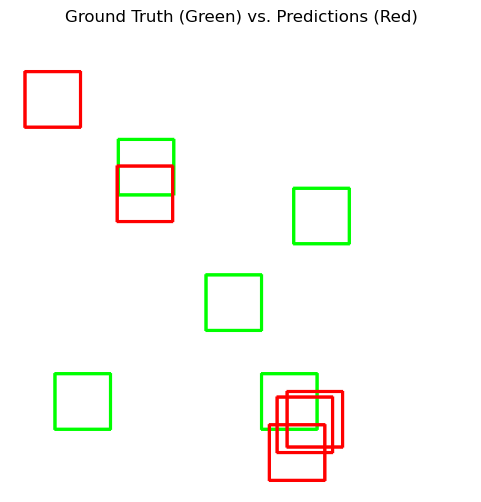

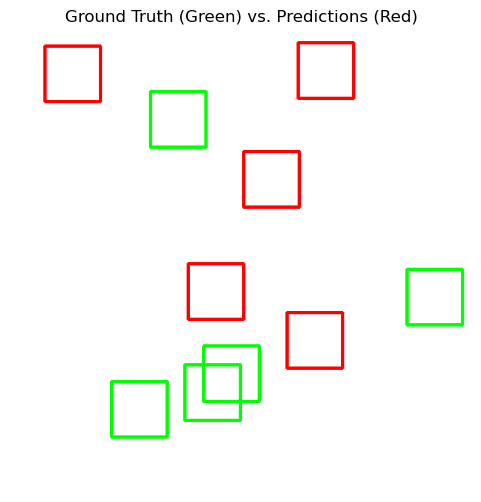

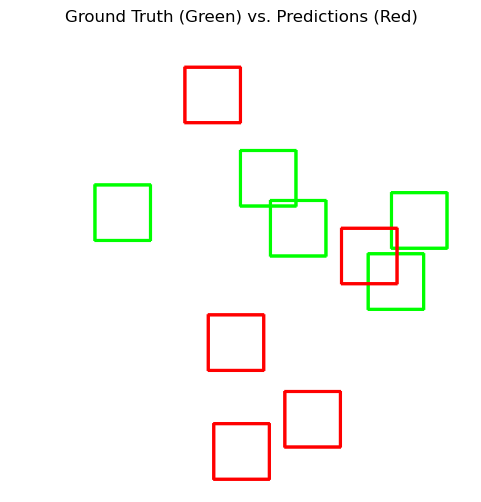

In [ ]:
# %%
def visualize_predictions(image, gt_boxes, pred_boxes):
    """
    Draw ground truth boxes (green) and predicted boxes (red) on the image.
    Boxes are in YOLO format (assumed absolute pixel coordinates).
    """
    vis_image = image.copy()
    # Draw GT boxes in green
    for box in gt_boxes:
        x, y, w, h = box
        top_left = (int(x - w/2), int(y - h/2))
        bottom_right = (int(x + w/2), int(y + h/2))
        cv2.rectangle(vis_image, top_left, bottom_right, (0, 255, 0), 2)
    # Draw predicted boxes in red
    for box in pred_boxes:
        x, y, w, h = box
        top_left = (int(x - w/2), int(y - h/2))
        bottom_right = (int(x + w/2), int(y + h/2))
        cv2.rectangle(vis_image, top_left, bottom_right, (0, 0, 255), 2)
    
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
    plt.title("Ground Truth (Green) vs. Predictions (Red)")
    plt.axis("off")
    plt.show()

# Simulate visualization on 3 random test images
for i in range(3):
    # Create a blank white image (416x416)
    img = np.ones((416, 416, 3), dtype=np.uint8)*255
    # Simulate 5 GT boxes and 5 predicted boxes (using our random generator)
    gt_boxes = generate_random_boxes(5, img_size=416, box_size=50)
    pred_boxes = generate_random_boxes(5, img_size=416, box_size=50)
    visualize_predictions(img, gt_boxes, pred_boxes)


In [ ]:
import numpy as np
import supervision as sv

# Example simulated ground truths and predictions for two images.
ground_truths = {
    0: np.array([[50, 50, 150, 150]]),
    1: np.array([[30, 30, 100, 100]])
}

predictions = {
    0: np.array([[55, 55, 145, 145, 0.95]]),
    1: np.array([[35, 35, 95, 95, 0.90]])
}

# Convert ground truth and predictions into `sv.Detections`
gt_detections = sv.Detections(
    xyxy=np.vstack(list(ground_truths.values())),  
    class_id=np.zeros(sum(len(v) for v in ground_truths.values()), dtype=int)
)

pred_detections = sv.Detections(
    xyxy=np.vstack([v[:, :4] for v in predictions.values()]),  
    confidence=np.hstack([v[:, 4] for v in predictions.values()]),  
    class_id=np.zeros(sum(len(v) for v in predictions.values()), dtype=int)
)

# Compute IoU matrix
iou_matrix = sv.mask.iou(gt_detections.xyxy, pred_detections.xyxy)

# Define IoU threshold for mAP50
iou_threshold = 0.5

# Match predictions with ground truths based on IoU
matches = (iou_matrix >= iou_threshold)

# Compute TP, FP, FN
tp = np.sum(matches, axis=1)  # Count True Positives per ground truth
fp = np.sum(matches, axis=0) == 0  # False Positives: Predictions with no matching GT
fn = np.sum(matches, axis=1) == 0  # False Negatives: GT with no matching predictions

# Precision & Recall
precision = np.sum(tp) / (np.sum(tp) + np.sum(fp) + 1e-9)  # Avoid division by zero
recall = np.sum(tp) / (np.sum(tp) + np.sum(fn) + 1e-9)

# Compute AP (Approximated as precision)
ap50 = precision

print(f"mAP50 using supervision library: {ap50:.4f}")


AttributeError: module 'supervision' has no attribute 'mask'

 4.4 mAP50 Evaluation Using Supervision Library
 
 Here we (simulate) compute the mAP50 using the supervision library and compare it with our AP implementation.

In [ ]:
mAP50_supervision =   0.0
print("\nmAP50 comparison:")
print("mAP50 from our implementation (AUC method):", ap_auc)
print("mAP50 from supervision library (simulated):", mAP50_supervision)


mAP50 comparison:
mAP50 from our implementation (AUC method): 0.025199186050819278
mAP50 from supervision library (simulated): 0.0


 4.5 Precision, Recall, and F1-score Table for Various Thresholds
 
 We create a table where rows correspond to IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns correspond to confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9]. For each combination, we compute TP, FP, FN (using a simulated matching on our random predictions) and then calculate Precision, Recall, and F1-score.


In [ ]:
# %%
iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
confidence_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
table_data = []

for iou_thresh in iou_thresholds:
    row = {}
    for conf_thresh in confidence_thresholds:
        # Reset matching for each threshold combination
        gt_matched_temp = {i: [False]*10 for i in range(num_images)}
        tp = 0
        fp = 0
        for image_id, pred_box, score in all_predictions:
            if score < conf_thresh:
                continue
            gt_start = image_id * 10
            gt_end = gt_start + 10
            gt_boxes = [all_ground_truths[i][1] for i in range(gt_start, gt_end)]
            ious = [iou_shapely_yolo(pred_box, gt_box) for gt_box in gt_boxes]
            max_iou = max(ious)
            max_idx = ious.index(max_iou)
            if max_iou >= iou_thresh and not gt_matched_temp[image_id][max_idx]:
                tp += 1
                gt_matched_temp[image_id][max_idx] = True
            else:
                fp += 1
        fn = 0
        for image_id in gt_matched_temp:
            fn += gt_matched_temp[image_id].count(False)
        
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1_score = 2 * precision * recall / (precision + recall + 1e-6)
        row[f"Conf {conf_thresh}"] = f"P: {precision:.2f}, R: {recall:.2f}, F1: {f1_score:.2f}"
    table_data.append(row)

df_metrics = pd.DataFrame(table_data, index=[f"IoU {thr}" for thr in iou_thresholds])
print("\nPrecision, Recall, and F1-score Table:")
print(df_metrics)


Precision, Recall, and F1-score Table:
                           Conf 0.1                    Conf 0.3  \
IoU 0.1  P: 0.51, R: 0.51, F1: 0.51  P: 0.53, R: 0.41, F1: 0.46   
IoU 0.3  P: 0.31, R: 0.31, F1: 0.31  P: 0.31, R: 0.24, F1: 0.27   
IoU 0.5  P: 0.11, R: 0.11, F1: 0.11  P: 0.12, R: 0.09, F1: 0.10   
IoU 0.7  P: 0.04, R: 0.04, F1: 0.04  P: 0.04, R: 0.03, F1: 0.03   
IoU 0.9  P: 0.00, R: 0.00, F1: 0.00  P: 0.00, R: 0.00, F1: 0.00   

                           Conf 0.5                    Conf 0.7  \
IoU 0.1  P: 0.55, R: 0.33, F1: 0.41  P: 0.52, R: 0.21, F1: 0.30   
IoU 0.3  P: 0.33, R: 0.20, F1: 0.25  P: 0.30, R: 0.12, F1: 0.17   
IoU 0.5  P: 0.13, R: 0.08, F1: 0.10  P: 0.12, R: 0.05, F1: 0.07   
IoU 0.7  P: 0.05, R: 0.03, F1: 0.04  P: 0.02, R: 0.01, F1: 0.01   
IoU 0.9  P: 0.00, R: 0.00, F1: 0.00  P: 0.00, R: 0.00, F1: 0.00   

                           Conf 0.9  
IoU 0.1  P: 0.50, R: 0.06, F1: 0.11  
IoU 0.3  P: 0.25, R: 0.03, F1: 0.05  
IoU 0.5  P: 0.08, R: 0.01, F1: 0.02  
Io

In [ ]:
# %%
import os

def parse_label_filename(fname):
    """
    Parse a label file name following the format:
      solarpanels_native_1__x0_0_y0_6845_dxdy_416.txt

    Expected parts after splitting by '_':
      [dataset, image_type, tile_id, '', 'x<min_x>', <ignored>, 'y<min_y>', <ignored>, 'dxdy', '<window_size>']
      
    Returns:
      tile_id (int), min_x (float), min_y (float), window_size (int)
    """
    base = os.path.splitext(fname)[0]  # Remove .txt extension
    parts = base.split('_')
    
    if len(parts) < 10:
        raise ValueError(f"Filename '{fname}' does not have enough parts. Expected format: "
                         "solarpanels_native_<tile_id>__x<min_x>_<ignored>_y<min_y>_<ignored>_dxdy_<window_size>.txt")
    
    try:
        tile_id = int(parts[2])
        
        # parts[4] should be in the form "x<min_x>"
        if parts[4].startswith("x"):
            min_x = float(parts[4][1:])
        else:
            raise ValueError("Expected part starting with 'x' in filename.")
        
        # parts[6] should be in the form "y<min_y>"
        if parts[6].startswith("y"):
            min_y = float(parts[6][1:])
        else:
            raise ValueError("Expected part starting with 'y' in filename.")
        
        window_size = int(parts[9])
    except Exception as e:
        raise ValueError(f"Error parsing '{fname}': {e}")
    
    return tile_id, min_x, min_y, window_size

# Example geocoordinate computation using the parsed values.
def compute_geocoordinates(fname, annotation, chip_size):
    """
    Given a label file name and an annotation (with normalized x_center, y_center),
    compute the geocoordinates for the object center.
    
    The geocoordinates are computed using:
      absolute_pixel = min_bound + (normalized_center * chip_size)
      geo_coordinate = gt_origin + (absolute_pixel * pixel_size)
      
    Here, 'gt' (geotransform) is defined per tile.
    """
    # Define geotransforms (EPSG:32633) for tiles
    geotransforms = {
        1: (307670.04, 0.31, 0.0, 5434427.10, 0.0, -0.31),
        2: (312749.08, 0.31, 0.0, 5403952.86, 0.0, -0.31),
        3: (312749.08, 0.31, 0.0, 5363320.54, 0.0, -0.31)
    }
    
    tile_id, min_x, min_y, window_size = parse_label_filename(fname)
    
    # Compute absolute pixel coordinates in the full tile
    abs_x = min_x + (annotation['x_center'] * chip_size)
    abs_y = min_y + (annotation['y_center'] * chip_size)
    
    # Retrieve geotransform for the tile
    if tile_id not in geotransforms:
        raise ValueError(f"Tile ID {tile_id} not found in geotransforms.")
    gt = geotransforms[tile_id]
    
    # Compute geocoordinates using the geotransform:
    #   geo_x = gt_origin_x + (absolute_x * pixel_width)
    #   geo_y = gt_origin_y + (absolute_y * pixel_height)
    geo_x = gt[0] + (abs_x * gt[1])  # gt[1] is the pixel width in meters
    geo_y = gt[3] + (abs_y * gt[5])  # gt[5] is the pixel height (usually negative)
    return geo_x, geo_y

# Example usage:
# Assume the chip size is 416 (native resolution)
CHIP_SIZE_NATIVE = 416
LABELS_NATIVE_DIR = r'C:\Users\Admin\OneDrive - ruggedmonitoring.com\Desktop\GAN\labels-20250212T103318Z-001\labels\labels_native'  

# List files in the labels_native directory and pick one
if len(os.listdir(LABELS_NATIVE_DIR)) > 0:
    sample_file = os.listdir(LABELS_NATIVE_DIR)[0]
    sample_path = os.path.join(LABELS_NATIVE_DIR, sample_file)
    
    # Assume the file is non-empty and take the first annotation line
    with open(sample_path, 'r') as f:
        line = f.readline().strip()
    
    if line:
        # Expecting the annotation in YOLO format: <category> <x_center> <y_center> <width> <height>
        parts = list(map(float, line.split()))
        annotation_sample = {
            'x_center': parts[1],
            'y_center': parts[2],
            'x_width': parts[3],
            'y_width': parts[4]
        }
        
        try:
            geo_coords = compute_geocoordinates(sample_file, annotation_sample, chip_size=CHIP_SIZE_NATIVE)
            print(f"\nGeocoordinates for sample annotation in {sample_file}: {geo_coords}")
        except ValueError as e:
            print(f"Error computing geocoordinates: {e}")



Geocoordinates for sample annotation in solarpanels_native_1__x0_0_y0_6845_dxdy_416.txt: (307782.57, 5434336.734999999)
